### Prerequisites

PyTorch Lightning is a higher level framework on top of PyTorch and can help you to automate some common tasks related setting up your training loop, 
scaling up scaling across distributed resources, and keeping track of trained models and how they perform. 

In [ ]:
!pip install pytorch-lightning
!pip install ipywidgets

### Please check if all the dependencies are working:

If this raises an error, please reach out so we can help ;)

In [9]:
# check imports
import torch
import pytorch_lightning as pl
import torchvision               # for datasets only

## PyTorch Lightning

Tons of things one could say about lightning :) This just checks for import from a file with a model.

trainer
Train loop, Validation loop, Test loop, Model or system of Models, Optimizer
.. maybe some of the nice gimmicks?
debate weather to link models with data by including train_dataloader, etc, or not :)

## Model Setup

In [3]:
import os

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import pytorch_lightning as pl

class MyModel(pl.LightningModule):

    def __init__(self, input_size=784, hidden_layers=None, output_size=10):
        super().__init__()
        self.save_hyperparameters()

        if hidden_layers is None:
            hidden_layers = [128, 64]

        # attach 
        self.layer_1 = nn.Linear(28 * 28, 128)
        self.layer_2 = nn.Linear(128, 256)
        self.layer_3 = nn.Linear(256, 10)

    def forward(self, x):
        batch_size, channels, width, height = x.size()

        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.relu(x)
        x = self.layer_3(x)

        x = F.log_softmax(x, dim=1)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
    
        tensorboard_logs = {'train_loss': loss}           # I mostly, think something like this should be mentioned
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return {'val_loss': loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        return {'val_loss': avg_loss}

    def configure_optimizers(self):
        return torch.optim.SGD(model.parameters(), lr=0.003)

/home/pq/AIM/training/Hands-On ML Bootstrap/venv/lib64/python3.9/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


## Training

In [6]:
from torchvision.datasets import MNIST

from pytorch_lightning import Trainer, seed_everything
seed_everything(0)

# data
mnist_train = MNIST("./data/", train=True, download=True, transform=transforms.ToTensor())
mnist_train = DataLoader(mnist_train, batch_size=32, num_workers=4)
mnist_val = MNIST("./data/", train=True, download=True, transform=transforms.ToTensor())
mnist_val = DataLoader(mnist_val, batch_size=32, num_workers=4)

Global seed set to 0
/home/pq/AIM/training/Hands-On ML Bootstrap/venv/lib64/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [56]:
# model
model = MyModel()

# most basic trainer, uses good defaults
trainer = Trainer(progress_bar_refresh_rate=20, max_epochs=10)
trainer.fit(model, mnist_train, mnist_val)   

Global seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 2.6 K 
-----------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 0


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Save a trained model

In [74]:
trainer.save_checkpoint("my_trained_model.ckpt")

### Load a trained model

In [8]:
model = MyModel.load_from_checkpoint(checkpoint_path="my_trained_model.ckpt")

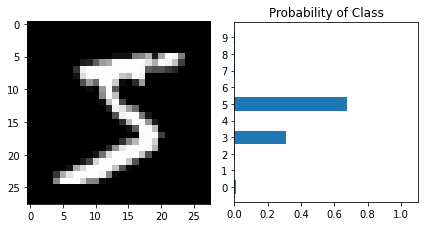

In [11]:
from utils import visualize_prediction

# get a sample for which you would like to generate a prediction
images, labels = next(iter(mnist_train))
image = images[0][0]

# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(images[0:1])

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
visualize_prediction(image, ps)

## A Earth System Data Example (e.g., Weatherbench, ...)?

Same drill as with the others :)